# Load and Preprocess Data

In [1]:

def loading_geo_data():
    import geopandas as gpd
    import fiona
    import pandas as pd
    
    # Path to your .gdb file
    file_path = "./HSR_KSATD2.gdb/"

    # Specify the layer name you're interested in
    layer_name = 'Farms'
    # Read the layer into a GeoDataFrame
    df_farms = gpd.read_file(file_path, layer=layer_name)
    layer_name = 'Property'
    df_property = gpd.read_file(file_path, layer=layer_name)
    layer_name = 'Wells'
    # Read the layer into a GeoDataFrame
    df_wells = gpd.read_file(file_path, layer=layer_name)
    return df_farms, df_property, df_wells


df_farms, df_property, df_wells = loading_geo_data()


In [2]:
import pandas as pd

df_wells = df_wells.rename(
    columns={
        "HSRCode": "well_id",
        "OB_HSRCode": "farm_id",
        "PossessionType": "well_possession_type",
        "IsActive": "well_is_active",
        "IrragationSource": "well_irrigation_source",
        "IrrigationType": "well_irrigation_type",
        "X": "well_longitude",
        "Y": "well_latitude",
        "Region": "well_region",
    }
)
df_wells = df_wells[['well_id', 'farm_id', 'well_possession_type', 'well_is_active', 'well_irrigation_source', 'well_irrigation_type',]]
df_wells['well_possession_type'] = df_wells['well_possession_type'].astype('category')
df_wells['well_is_active'] = df_wells['well_is_active'].astype('category')
df_wells['well_irrigation_source'] = df_wells['well_irrigation_source'].astype('category')
df_wells['well_irrigation_type'] = df_wells['well_irrigation_type'].astype('category')
categorical_columns = df_wells.drop(columns=['farm_id']).select_dtypes(include=['object', 'category']).columns.tolist()
def fill_missing_categorical(df, columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].replace(0,df[col].mode()[0])

fill_missing_categorical(df_wells, categorical_columns)

well_count = df_wells.groupby("farm_id").agg(well_count=pd.NamedAgg(column="well_id", aggfunc="count")).reset_index()
df_wells = df_wells.drop(columns=['well_id'])

df_wells_summary = pd.get_dummies(df_wells, columns=['well_possession_type','well_is_active','well_irrigation_source', 'well_irrigation_type'], dtype=int)
df_wells_summary = df_wells_summary.groupby("farm_id").sum().reset_index()
df_wells_summary = pd.merge(df_wells_summary, well_count, on='farm_id')
df_wells_summary


# Calculate percentages for irrigation sources and types
for col in df_wells_summary.columns:
    if col.startswith('well_') and col != 'well_count':
        df_wells_summary[f'{col}_percentage'] = df_wells_summary[col] / df_wells_summary['well_count']


df_wells_summary['sprinklers_count'] = df_wells_summary['well_count']
df_wells_summary['sprinklers_count_kw'] = df_wells_summary['well_count'] * 25

df_wells_summary.head()

/var/folders/r1/8bjwl1x93r9947_btv_5j4440000gn/T/ipykernel_95719/3090629733.py:25: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].replace(0,df[col].mode()[0])


,farm_id,well_possession_type_1,well_possession_type_2,well_is_active_1,well_is_active_2,well_irrigation_source_1,well_irrigation_source_2,well_irrigation_source_4,well_irrigation_source_5,well_irrigation_source_6,...,well_irrigation_source_10_percentage,well_irrigation_source_12_percentage,well_irrigation_type_1.0_percentage,well_irrigation_type_2.0_percentage,well_irrigation_type_3.0_percentage,well_irrigation_type_4.0_percentage,well_irrigation_type_6.0_percentage,well_irrigation_type_7.0_percentage,sprinklers_count,sprinklers_count_kw
0,01_00_000002,5,0,5,0,4,1,0,0,0,...,0.0,0.0,0.8,0.2,0.0,0.0,0.0,0.0,5,125
1,01_00_000003,5,0,5,0,5,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,125
2,01_00_000006,1,0,1,0,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,25
3,01_00_000008,2,0,2,0,1,1,0,0,0,...,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,2,50
4,01_00_000009,2,0,0,2,2,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,50


In [3]:
# Rename columns
rename_dict = {
    'HSRCode': 'activity_id',
    'OB_HSRCode': 'farm_id',
    'ActivityStatus': 'activity_status',
    'FarmType': 'farm_type',
    'MainCropsType': 'main_crop_type',
    'CropsType': 'crop_type',
    'IrragationSource': 'irrigation_source',
    'IrragationType': 'irrigation_type',
    'FarmingSeason': 'farming_season',
    'TotalArea': 'total_area_hectares',
    'ProductiveTreesNo': 'productive_trees_count',
    'ProtectedHouseNo': 'protected_house_count',
    'ProtectedHouseType': 'protected_house_type',
    'PlantationsNo': 'plantations_count',
    'PlantationsType': 'plantations_type'
}
df_farms = df_farms.rename(columns={k: v for k, v in rename_dict.items() if k in df_farms.columns})
df_farms['total_area_hectares'] = df_farms['total_area_hectares'].astype(float)
df_farms['productive_trees_count'] = df_farms['productive_trees_count'].astype(float)
df_farms['protected_house_count'] = df_farms['protected_house_count'].astype(float)
df_farms['plantations_count'] = df_farms['plantations_count'].astype(float)
df_farms['activity_id'] = df_farms['activity_id'].astype('category')
df_farms['farm_id'] = df_farms['farm_id'].astype('category')
df_farms['activity_status'] = df_farms['activity_status'].astype('category')
df_farms['farm_type'] = df_farms['farm_type'].astype('category')
df_farms['main_crop_type'] = df_farms['main_crop_type'].astype('category')
df_farms['crop_type'] = df_farms['crop_type'].astype('category')
df_farms['irrigation_source'] = df_farms['irrigation_source'].astype('category')
df_farms['irrigation_type'] = df_farms['irrigation_type'].astype('category')
df_farms['farming_season'] = df_farms['farming_season'].astype('category')
df_farms['protected_house_type'] = df_farms['protected_house_type'].astype('category')
df_farms['plantations_type'] = df_farms['plantations_type'].astype('category')


numeric_columns = df_farms.select_dtypes(include=['float', 'int']).columns.tolist()

categorical_columns = df_farms.drop(columns=['farm_id', 'activity_id', 'crop_type']).select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_columns:
    df_farms[col] = df_farms[col].fillna(df_farms[col].mode()[0])
    df_farms[col] = df_farms[col].replace(0, df_farms[col].mode()[0])

# # Create dummy variables for categorical columns
df_farms = pd.get_dummies(df_farms, columns=categorical_columns, prefix_sep='_', dtype=int)
# unique_crops = df_farms.groupby('farm_id')['crop_type'].nunique().reset_index()
# Prepare aggregation dictionary
agg_dict = {
    'activity_id': 'nunique',
    'crop_type': 'nunique',

}
agg_dict.update({col: 'sum' for col in numeric_columns})

# Add dummy columns to aggregation dictionary
dummy_columns = [col for col in df_farms.columns if '_' in col and col not in ['farm_id', 'activity_id', 'crop_type'] and col not in numeric_columns]
agg_dict.update({col: 'sum' for col in dummy_columns})

# # Group by farm_id and aggregate
df_farms_summary = df_farms.groupby('farm_id').agg(agg_dict).rename(columns={'activity_id': 'activity_count', 'crop_type': 'unique_crop_types_count'}).reset_index()

df_farms_summary = df_farms_summary.drop(columns=["X", "Y", "SHAPE_Length", "SHAPE_Area",])
df_farms_summary

/var/folders/r1/8bjwl1x93r9947_btv_5j4440000gn/T/ipykernel_95719/2883810874.py:42: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_farms[col] = df_farms[col].replace(0, df_farms[col].mode()[0])
/var/folders/r1/8bjwl1x93r9947_btv_5j4440000gn/T/ipykernel_95719/2883810874.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_farms_summary = df_farms.groupby('farm_id').agg(agg_dict).rename(columns={'activity_id': 'activity_count', 'crop_type': 'unique_crop_types_count'}).reset_index()


,farm_id,activity_count,unique_crop_types_count,total_area_hectares,productive_trees_count,protected_house_count,plantations_count,activity_status_1,activity_status_3,activity_status_4,...,farming_season_4.0,protected_house_type_1.0,protected_house_type_2.0,protected_house_type_3.0,protected_house_type_4.0,protected_house_type_6.0,protected_house_type_7.0,plantations_type_1.0,plantations_type_2.0,plantations_type_3.0
0,01_00_000002,6,2,55.035575,594.0,0.0,0.0,4,1,1,...,2,6,0,0,0,0,0,0,0,6
1,01_00_000003,5,1,67.494602,0.0,0.0,0.0,5,0,0,...,0,5,0,0,0,0,0,0,0,5
2,01_00_000006,1,1,30.682688,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,01_00_000008,11,3,46.750421,0.0,0.0,0.0,5,6,0,...,6,11,0,0,0,0,0,0,0,11
4,01_00_000009,2,1,27.911888,0.0,0.0,0.0,2,0,0,...,0,2,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17365,13_00_014341,4,2,30.365888,4564.0,0.0,0.0,4,0,0,...,0,4,0,0,0,0,0,0,0,4
17366,13_00_014422,1,1,13.711515,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
17367,13_00_016808,1,1,60.445241,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
17368,13_00_016813,3,2,87.881187,0.0,0.0,0.0,3,0,0,...,0,3,0,0,0,0,0,0,0,3


In [4]:
df_property = (
    df_property[["OB_HSRCode", "SHAPE_Area", "MainType"]].rename(
        columns={
            "OB_HSRCode": "farm_id",
            "SHAPE_Area": "property_area",
            "MainType": "property_main_type",
        }
    )
)
df_property

,farm_id,property_area,property_main_type
0,05_00_000030,3.565259e+06,3.0
1,05_00_000090,3.681615e+06,3.0
2,05_00_000051,2.555279e+06,3.0
3,05_00_000067,1.168098e+06,3.0
4,05_00_000177,1.337747e+06,3.0
...,...,...,...
18308,06_00_008951,6.254972e+05,1.0
18309,06_00_008965,8.418189e+05,1.0
18310,06_00_008968,7.502167e+05,1.0
18311,06_00_009342,1.697147e+06,1.0


In [5]:
import pandas as pd
import numpy as np

# Load the data
df_visits = pd.read_csv("./processed_data/visits_final.csv", usecols=['farm_id','total_electrical_load_kw'])
df_visits_processed = df_visits[(df_visits['total_electrical_load_kw'] > 0) ]


In [6]:

# Start with df_property as the base
df_integrated = df_property.copy()
# Merge with df_farms_summary
df_integrated = df_integrated.merge(df_farms_summary, on='farm_id', how='left')

# Merge with df_wells_summary
df_integrated = df_integrated.merge(df_wells_summary, on='farm_id', how='left')


# Merge with df_visits_processed
df_integrated = df_integrated.merge(df_visits_processed, on='farm_id', how='right')
df_integrated

,farm_id,property_area,property_main_type,activity_count,unique_crop_types_count,total_area_hectares,productive_trees_count,protected_house_count,plantations_count,activity_status_1,...,well_irrigation_source_12_percentage,well_irrigation_type_1.0_percentage,well_irrigation_type_2.0_percentage,well_irrigation_type_3.0_percentage,well_irrigation_type_4.0_percentage,well_irrigation_type_6.0_percentage,well_irrigation_type_7.0_percentage,sprinklers_count,sprinklers_count_kw,total_electrical_load_kw
0,01_00_000008,1.273708e+06,1.0,11.0,3.0,46.750421,0.0,0.0,0.0,5.0,...,0.0,0.5,0.000000,0.500000,0.0,0.0,0.0,2.0,50.0,1492.80
1,01_00_000012,1.449119e+06,1.0,3.0,2.0,42.246073,156.0,0.0,0.0,2.0,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,3.0,75.0,360.70
2,01_00_000014,1.710511e+06,5.0,14.0,1.0,96.493831,0.0,0.0,0.0,6.0,...,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,3.0,75.0,609.50
3,01_00_000016,1.171881e+06,1.0,4.0,3.0,86.170176,0.0,0.0,0.0,4.0,...,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,2.0,50.0,1026.15
4,01_00_000017,2.063067e+06,3.0,3.0,1.0,61.862922,683.0,0.0,0.0,1.0,...,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,3.0,75.0,398.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,07_00_013777,1.064688e+06,1.0,1.0,1.0,82.734726,0.0,0.0,0.0,1.0,...,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,1.0,25.0,342.05
10867,07_00_013781,5.385670e+05,1.0,1.0,1.0,41.266395,0.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,1.0,25.0,472.60
10868,07_00_013868,2.351574e+06,1.0,6.0,3.0,81.160858,5902.0,0.0,0.0,6.0,...,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,2.0,50.0,342.05
10869,07_00_013869,1.566152e+06,3.0,2.0,2.0,82.228900,0.0,0.0,0.0,2.0,...,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,2.0,50.0,398.00


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

# Load the data
df = df_integrated.copy()

# Separate HASAR features from visits data
# hasar_columns = [
#     'farm_id', 'property_area', 'property_main_type', 'activity_count', 
#     'unique_crop_types_count', 'total_area_hectares', 'productive_trees_count', 
#     'protected_house_count', 'plantations_count'
# ] + [col for col in df.columns if col.startswith(('activity_status_', 'farm_type_', 
#     'main_crop_type_', 'irrigation_source_', 'irrigation_type_', 'farming_season_', 
#     'protected_house_type_', 'plantations_type_', 'well_'))]


df_hasar = df_integrated.drop(columns=['total_electrical_load_kw'])
df_visits = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Handle missing values in HASAR data
# imputer = KNNImputer(n_neighbors=5)
# df_hasar_imputed = pd.DataFrame(imputer.fit_transform(df_hasar), columns=df_hasar.columns)
df_hasar_imputed = df_hasar.copy()
# Normalize numerical features
scaler = StandardScaler()
numerical_features = df_hasar_imputed.select_dtypes(include=[np.number]).columns
df_hasar_imputed[numerical_features] = scaler.fit_transform(df_hasar_imputed[numerical_features])

# Feature selection
features = [col for col in df_hasar_imputed.columns if col not in ['farm_id']]
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
selector = selector.fit(df_hasar_imputed[features], df_visits['total_electrical_load_kw'])
selected_features = df_hasar_imputed[features].columns[selector.get_support()]
print(selected_features)
# Prepare data for modeling
X = df_hasar_imputed[selected_features]
y = df_visits['total_electrical_load_kw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.3],
        'kernel': ['rbf', 'linear']
    }
}

# Perform RandomizedSearchCV for each model
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTuning {name}...")
    random_search = RandomizedSearchCV(model, param_distributions=param_grids[name],
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Evaluate the best model from the random search
    y_pred = random_search.best_estimator_.predict(X_test)
    evaluate_model(y_test, y_pred, f"{name} (after tuning)")
    
    # Update the best model if this one performed better
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_model = random_search.best_estimator_

# Use the best model to make final predictions
df_hasar_imputed['estimated_total_electrical_load_kw'] = best_model.predict(df_hasar_imputed[selected_features])

# Merge predictions with actual values
results = pd.merge(df_hasar_imputed[['farm_id', 'estimated_total_electrical_load_kw']], 
                   df_visits, on='farm_id', how='left')

# Print results
print("\nSummary statistics of actual vs estimated total electrical load:")
print(results[['total_electrical_load_kw', 'estimated_total_electrical_load_kw']].describe())

# Calculate final evaluation metrics
final_predictions = results.dropna()
evaluate_model(final_predictions['total_electrical_load_kw'], 
               final_predictions['estimated_total_electrical_load_kw'], 
               "Final Model")

# Save the results
results.to_csv('hasar_only_farm_consumption_estimates.csv', index=False)

# Print feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({'feature': selected_features, 
                                'importance': best_model.feature_importances_})
    importances = importances.sort_values('importance', ascending=False)
    print("\nTop 10 most important features:")
    print(importances.head(10))

Index(['property_area', 'property_main_type', 'activity_count',
       'unique_crop_types_count', 'total_area_hectares',
       'productive_trees_count', 'protected_house_count', 'activity_status_1',
       'activity_status_3', 'activity_status_4', 'activity_status_6',
       'farm_type_1.0', 'farm_type_2.0', 'farm_type_6.0', 'farm_type_7.0',
       'main_crop_type_1.0', 'main_crop_type_2.0', 'main_crop_type_4.0',
       'main_crop_type_6.0', 'main_crop_type_8.0', 'main_crop_type_10.0',
       'main_crop_type_15.0', 'irrigation_source_1.0', 'irrigation_source_2.0',
       'irrigation_source_12.0', 'irrigation_type_1.0', 'irrigation_type_2.0',
       'irrigation_type_3.0', 'irrigation_type_6.0', 'farming_season_1.0',
       'farming_season_2.0', 'farming_season_3.0', 'farming_season_4.0',
       'protected_house_type_1.0', 'plantations_type_3.0',
       'well_possession_type_1', 'well_is_active_1',
       'well_irrigation_source_1', 'well_irrigation_source_2',
       'well_irrigation_ty

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 659, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import joblib
import shap

class NonNegativeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self

    def predict(self, X):
        predictions = self.base_estimator.predict(X)
        return np.maximum(predictions, 0)

def load_and_preprocess_data(file_path):
    df = df_integrated.copy()
    
    # Top 10 important features based on SHAP values
    important_features = [
        'irrigation_source_2.0', 'total_area_hectares', 'unique_crop_types_count',
        'irrigation_type_2.0', 'property_area', 'productive_trees_count',
        'main_crop_type_6.0', 'activity_count', 'main_crop_type_15.0',
        'irrigation_type_4.0', 'well_count'
    ]
    
    # Add 'farm_id' for joining purposes
    columns_to_keep = ['farm_id'] + important_features
    
    df_hasar = df[columns_to_keep]
    df_target = df[['farm_id', 'total_electrical_load_kw']]
    
    return df_hasar, df_target

def engineer_features(df):
    df['trees_per_hectare'] = df['productive_trees_count'] / df['total_area_hectares']
    df['irrigation_intensity'] = df['irrigation_type_2.0'] * df['total_area_hectares']
    df['well_density'] = df['well_count'] / df['total_area_hectares']
    df['area_per_activity'] = df['total_area_hectares'] / df['activity_count']
    return df

def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', QuantileTransformer(output_distribution='normal'))
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])
    return preprocessor

def create_ensemble_model():
    gb_model = NonNegativeRegressor(GradientBoostingRegressor(random_state=42))
    rf_model = NonNegativeRegressor(RandomForestRegressor(random_state=42))

    ensemble = VotingRegressor([
        ('gb', gb_model),
        ('rf', rf_model)
    ])
    return ensemble

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

def perform_cross_validation(model, X, y, cv=5):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
    mae_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"R2 Score: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
    print(f"RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
    print(f"MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

def compute_shap_values(model, X):
    explainer = shap.TreeExplainer(model.estimators_[0].base_estimator)
    shap_values = explainer.shap_values(X)
    
    feature_names = X.columns
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame(list(zip(feature_names, shap_sum)), columns=['feature', 'importance'])
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    print("\nFeature importance based on SHAP values:")
    print(importance_df)
    
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.close()

def save_pipeline(pipeline, feature_names, file_path):
    pipeline_data = {
        'pipeline': pipeline,
        'feature_names': feature_names
    }
    joblib.dump(pipeline_data, file_path)

def main():
    # Load and preprocess data
    df_hasar, df_target = load_and_preprocess_data('df_integrated.csv')
    df_hasar = engineer_features(df_hasar)

    # Prepare data for modeling
    X = df_hasar.drop('farm_id', axis=1)
    y = df_target['total_electrical_load_kw']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create preprocessor and model
    preprocessor = create_preprocessor(X)
    ensemble = create_ensemble_model()

    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', ensemble)
    ])

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'model__gb__base_estimator__n_estimators': [100, 200, 300],
        'model__gb__base_estimator__max_depth': [3, 4, 5],
        'model__gb__base_estimator__learning_rate': [0.01, 0.1, 0.2],
        'model__rf__base_estimator__n_estimators': [100, 200, 300],
        'model__rf__base_estimator__max_depth': [10, 20, 30, None],
        'model__rf__base_estimator__min_samples_split': [2, 5, 10],
    }

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Get the best model
    best_pipeline = random_search.best_estimator_

    # Perform cross-validation
    print("\nPerforming cross-validation on the best model:")
    perform_cross_validation(best_pipeline, X, y)

    # Make predictions on the test set
    y_pred_test = best_pipeline.predict(X_test)

    # Evaluate the model on the test set
    print("\nEvaluating the model on the test set:")
    evaluate_model(y_test, y_pred_test, "Best Ensemble Model (Test Set)")

    # Make predictions on the entire dataset
    y_pred_all = best_pipeline.predict(X)

    # Merge predictions with actual values
    results = pd.DataFrame({
        'farm_id': df_hasar['farm_id'],
        'actual_load': df_target['total_electrical_load_kw'],
        'estimated_load': y_pred_all
    })

    # Print summary statistics
    print("\nSummary statistics of actual vs estimated total electrical load:")
    print(results[['actual_load', 'estimated_load']].describe())

    # Calculate final evaluation metrics
    print("\nFinal evaluation metrics on the entire dataset:")
    evaluate_model(results['actual_load'], results['estimated_load'], "Final Ensemble Model (Full Dataset)")

    # Compute SHAP values
    compute_shap_values(best_pipeline.named_steps['model'], X)

    # Save the results
    results.to_csv('ensemble_hasar_farm_consumption_estimates.csv', index=False)

    # Save the pipeline and feature names
    save_pipeline(best_pipeline, X.columns.tolist(), 'hasar_farm_pipeline.joblib')

if __name__ == "__main__":
    main()


Performing cross-validation on the best model:

Cross-Validation Results (mean ± std):
R2 Score: 0.328 ± 0.025
RMSE: 202.500 ± 7.272
MAE: 128.781 ± 1.766

Evaluating the model on the test set:

Evaluation metrics for Best Ensemble Model (Test Set):
MAE: 127.84
RMSE: 195.93
R2 Score: 0.34

Summary statistics of actual vs estimated total electrical load:
        actual_load  estimated_load
count  10871.000000    10871.000000
mean     350.052908      351.704628
std      247.612605      138.376601
min        7.460000      118.998257
25%      236.500000      277.316278
50%      323.400000      326.683116
75%      398.000000      388.422214
max     4291.500000     3069.514947

Final evaluation metrics on the entire dataset:

Evaluation metrics for Final Ensemble Model (Full Dataset):
MAE: 105.70
RMSE: 165.88
R2 Score: 0.55

Feature importance based on SHAP values:
                    feature   importance
1       total_area_hectares  1014.171143
10               well_count    86.085157
4    

In [62]:
# Inference Code Very Important
import pandas as pd
import joblib

def load_pipeline(file_path):
    return joblib.load(file_path)

def inference(pipeline_data, new_data):
    pipeline = pipeline_data['pipeline']
    feature_names = pipeline_data['feature_names']

    # Ensure new_data has all the required features
    for feature in feature_names:
        
        if feature not in new_data.columns:
            print(f"Feature '{feature}' not found in the new data.")
            
            new_data[feature] = 0  # or any appropriate default value

    # Select only the features used during training
    new_data = new_data[feature_names]
    print(new_data)

    # Make predictions
    predictions = pipeline.predict(new_data)

    return predictions

def main():
    # Load the saved pipeline
    pipeline_data = load_pipeline('hasar_farm_pipeline.joblib')

    # Create some sample new data (adjust this according to your feature set)
    new_data = df_integrated.iloc[[3],:]
    

    # Make predictions on new data
    predictions = inference(pipeline_data, new_data)

    print("Predictions for new data:")
    for i, pred in enumerate(predictions):
        print(f"Farm {i+1}: Estimated electrical load: {pred:.2f} kW")

if __name__ == "__main__":
    main()

Feature 'trees_per_hectare' not found in the new data.
Feature 'irrigation_intensity' not found in the new data.
Feature 'well_density' not found in the new data.
Feature 'area_per_activity' not found in the new data.
   irrigation_source_2.0  total_area_hectares  unique_crop_types_count  \
3                    4.0            86.170176                      3.0   

   irrigation_type_2.0  property_area  productive_trees_count  \
3                  0.0   1.171881e+06                     0.0   

   main_crop_type_6.0  activity_count  main_crop_type_15.0  \
3                 0.0             4.0                  0.0   

   irrigation_type_4.0  well_count  trees_per_hectare  irrigation_intensity  \
3                  0.0         2.0                  0                     0   

   well_density  area_per_activity  
3             0                  0  
Predictions for new data:
Farm 1: Estimated electrical load: 446.63 kW


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load and prepare your features (HASAR data only)
df_features = df_integrated.copy().drop(columns=['total_electrical_load_kw'])  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = df_integrated.copy()

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter grid for RandomizedSearchCV
param_grid = {
    'feature_selection__estimator__n_estimators': [100, 200],
    'feature_selection__estimator__max_depth': [None, 10, 20],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Evaluate the model
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

evaluate_model(y_test, y_pred, "Random Forest with Proper Preprocessing")

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_pipeline, X, y, cv=cv, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean R2 score: {cv_scores.mean()}")



Evaluation metrics for Random Forest with Proper Preprocessing:
MAE: 123.52
RMSE: 190.42
R2 Score: 0.37
Cross-validated R2 scores: [0.34660542 0.31796785 0.32114235 0.33086074 0.34876533]
Mean R2 score: 0.33306834002160624


In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBRegressor

# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy().drop(columns=['total_electrical_load_kw'])  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = df_integrated.copy()

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_count', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                df_merged[feature_name] = df_merged['well_count'] / df_merged['total_area_hectares']
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipelines
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Set up hyperparameter grids
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt']
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train_log)

# Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_train, y_train_log)

# Best models
best_pipeline_rf = random_search_rf.best_estimator_
best_pipeline_xgb = random_search_xgb.best_estimator_

# Make predictions on the test set
y_pred_log_rf = best_pipeline_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)

y_pred_log_xgb = best_pipeline_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

# Evaluate Random Forest
evaluate_model(y_test_actual, y_pred_rf, "Random Forest with Log-Transformed Target")

# Evaluate XGBoost
evaluate_model(y_test_actual, y_pred_xgb, "XGBoost with Log-Transformed Target")

# Ensemble predictions
y_pred_ensemble = (y_pred_rf + y_pred_xgb) / 2

# Evaluate Ensemble Model
evaluate_model(y_test_actual, y_pred_ensemble, "Ensemble Model (Average of RF and XGBoost)")

# Cross-validation for Ensemble Model
mae_scores = []
rmse_scores = []
r2_scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in cv.split(X):
    X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
    y_cv_train_log, y_cv_test_log = y_log.iloc[train_index], y_log.iloc[test_index]
    y_cv_test_actual = np.expm1(y_cv_test_log)
    
    # Fit Random Forest
    best_pipeline_rf.fit(X_cv_train, y_cv_train_log)
    y_pred_log_rf_cv = best_pipeline_rf.predict(X_cv_test)
    y_pred_rf_cv = np.expm1(y_pred_log_rf_cv)
    
    # Fit XGBoost
    best_pipeline_xgb.fit(X_cv_train, y_cv_train_log)
    y_pred_log_xgb_cv = best_pipeline_xgb.predict(X_cv_test)
    y_pred_xgb_cv = np.expm1(y_pred_log_xgb_cv)
    
    # Ensemble predictions
    y_pred_ensemble_cv = (y_pred_rf_cv + y_pred_xgb_cv) / 2
    
    # Evaluate
    mae = mean_absolute_error(y_cv_test_actual, y_pred_ensemble_cv)
    rmse = np.sqrt(mean_squared_error(y_cv_test_actual, y_pred_ensemble_cv))
    r2 = r2_score(y_cv_test_actual, y_pred_ensemble_cv)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Display cross-validated metrics
print(f"\nCross-validated MAE scores: {mae_scores}")
print(f"Mean MAE score: {np.mean(mae_scores):.2f}")

print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Mean RMSE score: {np.mean(rmse_scores):.2f}")

print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Mean R2 score: {np.mean(r2_scores):.4f}")



Evaluation metrics for Random Forest with Log-Transformed Target:
MAE: 118.09
RMSE: 199.03
R2 Score: 0.3150

Evaluation metrics for XGBoost with Log-Transformed Target:
MAE: 117.31
RMSE: 196.40
R2 Score: 0.3330

Evaluation metrics for Ensemble Model (Average of RF and XGBoost):
MAE: 117.34
RMSE: 197.28
R2 Score: 0.3270

Cross-validated MAE scores: [np.float64(117.37932336394925), np.float64(119.30180086019266), np.float64(120.49022500821012), np.float64(122.07405813160135), np.float64(129.14229762748707)]
Mean MAE score: 121.68
Cross-validated RMSE scores: [np.float64(197.00197883254577), np.float64(207.27032308142196), np.float64(195.0389118708773), np.float64(203.89322137584), np.float64(234.52711865801876)]
Mean RMSE score: 207.55
Cross-validated R2 scores: [0.3288486930841722, 0.3078377217987891, 0.308770122868294, 0.2999795909984345, 0.23664271061289877]
Mean R2 score: 0.2964


In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy().drop(columns=['total_electrical_load_kw'])  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = df_integrated.copy()

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_count', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                df_merged[feature_name] = df_merged['well_count'] / df_merged['total_area_hectares']
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter grid for RandomizedSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train_log)

# Evaluate the model
best_rf_pipeline = random_search.best_estimator_

# Make predictions on the test set
y_pred_log = best_rf_pipeline.predict(X_test)

# Inverse transform the predictions
y_pred = np.expm1(y_pred_log)  # Use expm1 to reverse log1p

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

evaluate_model(y_test_actual, y_pred, "Random Forest with New Features and Log-Transformed Target")

# Perform cross-validation on the full dataset
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_pipeline, X, y_log, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-validated RMSE scores: {cv_rmse_scores}")
print(f"Mean RMSE score: {cv_rmse_scores.mean()}")

# Compute R2 scores during cross-validation
cv_r2_scores = cross_val_score(best_rf_pipeline, X, y_log, cv=cv, scoring='r2', n_jobs=-1)
print(f"Cross-validated R2 scores: {cv_r2_scores}")
print(f"Mean R2 score: {cv_r2_scores.mean()}")



Evaluation metrics for Random Forest with New Features and Log-Transformed Target:
MAE: 117.78
RMSE: 198.71
R2 Score: 0.32
Cross-validated RMSE scores: [0.51168469 0.50378386 0.53795992 0.52850403 0.53671985]
Mean RMSE score: 0.5237304711930477
Cross-validated R2 scores: [0.38623499 0.40019886 0.33590525 0.34261801 0.3664779 ]
Mean R2 score: 0.36628700290990646


In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor



# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy().drop(columns=['total_electrical_load_kw'])  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = df_integrated.copy()

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_count', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                # Ensure well_id is a count, not an identifier
                if 'well_count' in df_merged.columns:
                    df_merged[feature_name] = df_merged['well_count'] / df_merged['total_area_hectares']
                else:
                    print(f"Cannot create feature '{feature_name}' because 'well_id' column is missing.")
                    df_merged[feature_name] = 0
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the base learners
# Random Forest pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# XGBoost pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Hyperparameter grids
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

# Perform RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train_log)

# Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_train, y_train_log)

# Best estimators
best_pipeline_rf = random_search_rf.best_estimator_
best_pipeline_xgb = random_search_xgb.best_estimator_

# Define the stacking regressor
estimators = [
    ('rf', best_pipeline_rf),
    ('xgb', best_pipeline_xgb)
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Fit the stacking regressor
stacking_regressor.fit(X_train, y_train_log)

# Make predictions
y_pred_log_stack = stacking_regressor.predict(X_test)
y_pred_stack = np.expm1(y_pred_log_stack)

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

# Evaluate the stacking regressor
def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

# Evaluate individual models
# Random Forest
y_pred_log_rf = best_pipeline_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)
evaluate_model(y_test_actual, y_pred_rf, "Random Forest with Log-Transformed Target")

# XGBoost
y_pred_log_xgb = best_pipeline_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
evaluate_model(y_test_actual, y_pred_xgb, "XGBoost with Log-Transformed Target")

# Evaluate stacking regressor
evaluate_model(y_test_actual, y_pred_stack, "Stacking Regressor (Meta-Learner)")

# Cross-validation for stacking regressor
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacking_regressor, X, y_log, cv=cv, scoring='r2', n_jobs=-1)
print(f"\nCross-validated R2 scores for Stacking Regressor: {cv_scores}")
print(f"Mean R2 score: {cv_scores.mean():.4f}")



Evaluation metrics for Random Forest with Log-Transformed Target:
MAE: 117.78
RMSE: 198.71
R2 Score: 0.3172

Evaluation metrics for XGBoost with Log-Transformed Target:
MAE: 117.57
RMSE: 196.27
R2 Score: 0.3338

Evaluation metrics for Stacking Regressor (Meta-Learner):
MAE: 116.80
RMSE: 194.23
R2 Score: 0.3476

Cross-validated R2 scores for Stacking Regressor: [0.39033692 0.40524829 0.34535852 0.35386417 0.37744808]
Mean R2 score: 0.3745


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

# Importing Alternative Algorithms
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.base import BaseEstimator, TransformerMixin

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ----------------------- Custom Transformer for Outlier Capping -----------------------

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, factor=1.5):
        """
        Cap the outliers in specified variables using the IQR method.

        Parameters:
        - variables: list of column names to apply capping.
        - factor: multiplier for the IQR to define the cap.
        """
        self.variables = variables
        self.factor = factor

    def fit(self, X, y=None):
        self.cap_dict_ = {}
        for var in self.variables:
            Q1 = X[var].quantile(0.25)
            Q3 = X[var].quantile(0.75)
            IQR = Q3 - Q1
            lower_cap = Q1 - self.factor * IQR
            upper_cap = Q3 + self.factor * IQR
            self.cap_dict_[var] = (lower_cap, upper_cap)
        return self

    def transform(self, X):
        X_capped = X.copy()
        for var in self.variables:
            lower_cap, upper_cap = self.cap_dict_[var]
            X_capped[var] = np.where(
                X_capped[var] < lower_cap, lower_cap,
                np.where(X_capped[var] > upper_cap, upper_cap, X_capped[var])
            )
        return X_capped

# ----------------------- Data Preparation -----------------------

# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy().drop(columns=['total_electrical_load_kw'])  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = df_integrated.copy()

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_count', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                # Ensure well_id is a count, not an identifier
                if 'well_count' in df_merged.columns:
                    df_merged[feature_name] = df_merged['well_count'] / df_merged['total_area_hectares']
                else:
                    print(f"Cannot create feature '{feature_name}' because 'well_id' column is missing.")
                    df_merged[feature_name] = 0
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

print(X.shape, X.columns.tolist(), X)

# ----------------------- Handle Outliers in the Target Variable -----------------------

# Initialize OutlierCapper for the target variable
target_capper = OutlierCapper(variables=['total_electrical_load_kw'], factor=1.5)
y_capped = target_capper.fit_transform(X.assign(total_electrical_load_kw=y))['total_electrical_load_kw']

# Apply log transformation
y_log = np.log1p(y_capped)

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# ----------------------- Split the Data -----------------------

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# ----------------------- Preprocessing Pipelines -----------------------

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

variables_to_cap = numeric_features  # You can customize this list

# Update the numeric transformer pipeline
numeric_transformer = Pipeline(steps=[
    ('outlier_capper', OutlierCapper(variables=variables_to_cap, factor=1.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ----------------------- Define Base Learners Pipelines -----------------------

# Random Forest pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# XGBoost pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# LightGBM pipeline
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(verbose=-1, random_state=42))
])

# CatBoost pipeline
pipeline_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=42, verbose=0))
])

# Neural Network pipeline
pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(random_state=42, max_iter=500))
])

# ----------------------- Define Hyperparameter Grids -----------------------

param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

param_grid_lgbm = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__num_leaves': [31, 50, 100],
    'regressor__subsample': [0.7, 0.8, 1.0]
}

param_grid_cat = {
    'regressor__iterations': [500, 1000],
    'regressor__depth': [4, 6, 8],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__l2_leaf_reg': [1, 3, 5, 7, 9]
}

param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(100,), (100, 50), (100, 100, 50)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__solver': ['adam', 'lbfgs'],
    'regressor__alpha': [0.0001, 0.001, 0.01],
    'regressor__learning_rate': ['constant', 'adaptive']
}

# ----------------------- Hyperparameter Tuning with RandomizedSearchCV -----------------------

# Function to perform RandomizedSearchCV
def randomized_search(pipeline, param_distributions, X, y, n_iter, cv, scoring, random_state=42):
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1
    )
    search.fit(X, y)
    return search

# Define cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform RandomizedSearchCV for each model
print("Tuning Random Forest...")
random_search_rf = randomized_search(
    pipeline_rf,
    param_grid_rf,
    X_train,
    y_train_log,
    n_iter=10,
    cv=cv_strategy,
    scoring='neg_mean_squared_error'  # You can choose 'neg_root_mean_squared_error' or others
)

print("Tuning XGBoost...")
random_search_xgb = randomized_search(
    pipeline_xgb,
    param_grid_xgb,
    X_train,
    y_train_log,
    n_iter=10,
    cv=cv_strategy,
    scoring='neg_mean_squared_error'
)

print("Tuning LightGBM...")
random_search_lgbm = randomized_search(
    pipeline_lgbm,
    param_grid_lgbm,
    X_train,
    y_train_log,
    n_iter=10,
    cv=cv_strategy,
    scoring='neg_mean_squared_error'
)

print("Tuning CatBoost...")
random_search_cat = randomized_search(
    pipeline_cat,
    param_grid_cat,
    X_train,
    y_train_log,
    n_iter=5,  # CatBoost can be time-consuming; reduce iterations if necessary
    cv=cv_strategy,
    scoring='neg_mean_squared_error'
)

print("Tuning MLPRegressor...")
random_search_mlp = randomized_search(
    pipeline_mlp,
    param_grid_mlp,
    X_train,
    y_train_log,
    n_iter=10,
    cv=cv_strategy,
    scoring='neg_mean_squared_error'
)

# ----------------------- Retrieve Best Estimators -----------------------

best_pipeline_rf = random_search_rf.best_estimator_
best_pipeline_xgb = random_search_xgb.best_estimator_
best_pipeline_lgbm = random_search_lgbm.best_estimator_
best_pipeline_cat = random_search_cat.best_estimator_
best_pipeline_mlp = random_search_mlp.best_estimator_

# ----------------------- Define the Enhanced Stacking Regressor -----------------------

# Update estimators list to include all base learners
estimators = [
    ('rf', best_pipeline_rf),
    ('xgb', best_pipeline_xgb),
    ('lgbm', best_pipeline_lgbm),
    ('cat', best_pipeline_cat),
    ('mlp', best_pipeline_mlp)
]

# Original Stacking Regressor with LinearRegression as Meta-Learner
stacking_regressor_lr = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    passthrough=False  # Set to True if you want to include original features in the meta-learner
)

# ----------------------- Define and Tune Stacking Regressors with Ridge and Lasso Meta-Learners -----------------------

# Define stacking regressors with Ridge and Lasso as meta-learners
stacking_regressor_ridge = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=42),
    n_jobs=-1,
    passthrough=False
)

stacking_regressor_lasso = StackingRegressor(
    estimators=estimators,
    final_estimator=Lasso(random_state=42),
    n_jobs=-1,
    passthrough=False
)

# Define hyperparameter grids for meta-learners
param_grid_meta_ridge = {
    'final_estimator__alpha': [0.1, 1.0, 10.0, 100.0]
}

param_grid_meta_lasso = {
    'final_estimator__alpha': [0.001, 0.01, 0.1, 1.0]
}

# Perform RandomizedSearchCV for Stacking Regressor with Ridge Meta-Learner
print("Tuning Stacking Regressor with Ridge Meta-Learner...")
stacking_ridge_search = RandomizedSearchCV(
    stacking_regressor_ridge,
    param_distributions=param_grid_meta_ridge,
    n_iter=4,  # Number of alpha values
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
stacking_ridge_search.fit(X_train, y_train_log)

# Perform RandomizedSearchCV for Stacking Regressor with Lasso Meta-Learner
print("Tuning Stacking Regressor with Lasso Meta-Learner...")
stacking_lasso_search = RandomizedSearchCV(
    stacking_regressor_lasso,
    param_distributions=param_grid_meta_lasso,
    n_iter=4,  # Number of alpha values
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
stacking_lasso_search.fit(X_train, y_train_log)

# Retrieve Best Stacking Regressors
best_stacking_lr = stacking_regressor_lr  # Original Stacking Regressor
best_stacking_ridge = stacking_ridge_search.best_estimator_
best_stacking_lasso = stacking_lasso_search.best_estimator_

# ----------------------- Fit the Stacking Regressors -----------------------

# Fit the original Stacking Regressor (if not already fitted)
print("Fitting the original Stacking Regressor with LinearRegression...")
stacking_regressor_lr.fit(X_train, y_train_log)

# The stacking regressors with Ridge and Lasso have already been fitted during RandomizedSearchCV

# ----------------------- Make Predictions -----------------------

# Predictions with original Stacking Regressor (LinearRegression)
y_pred_log_stack_lr = stacking_regressor_lr.predict(X_test)
y_pred_stack_lr = np.expm1(y_pred_log_stack_lr)  # Inverse log transformation

# Predictions with Stacking Regressor (Ridge)
y_pred_log_stack_ridge = best_stacking_ridge.predict(X_test)
y_pred_stack_ridge = np.expm1(y_pred_log_stack_ridge)  # Inverse log transformation

# Predictions with Stacking Regressor (Lasso)
y_pred_log_stack_lasso = best_stacking_lasso.predict(X_test)
y_pred_stack_lasso = np.expm1(y_pred_log_stack_lasso)  # Inverse log transformation

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

# ----------------------- Evaluation Function -----------------------

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

# ----------------------- Evaluate Individual Models -----------------------

# Random Forest
y_pred_log_rf = best_pipeline_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)
evaluate_model(y_test_actual, y_pred_rf, "Random Forest with Log-Transformed Target")

# XGBoost
y_pred_log_xgb = best_pipeline_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
evaluate_model(y_test_actual, y_pred_xgb, "XGBoost with Log-Transformed Target")

# LightGBM
y_pred_log_lgbm = best_pipeline_lgbm.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_log_lgbm)
evaluate_model(y_test_actual, y_pred_lgbm, "LightGBM with Log-Transformed Target")

# CatBoost
y_pred_log_cat = best_pipeline_cat.predict(X_test)
y_pred_cat = np.expm1(y_pred_log_cat)
evaluate_model(y_test_actual, y_pred_cat, "CatBoost with Log-Transformed Target")

# MLPRegressor
y_pred_log_mlp = best_pipeline_mlp.predict(X_test)
y_pred_mlp = np.expm1(y_pred_log_mlp)
evaluate_model(y_test_actual, y_pred_mlp, "MLPRegressor with Log-Transformed Target")

# ----------------------- Evaluate Stacking Regressors -----------------------

# Original Stacking Regressor (LinearRegression)
evaluate_model(y_test_actual, y_pred_stack_lr, "Stacking Regressor with LinearRegression Meta-Learner")

# Stacking Regressor with Ridge Meta-Learner
evaluate_model(y_test_actual, y_pred_stack_ridge, "Stacking Regressor with Ridge Meta-Learner")

# Stacking Regressor with Lasso Meta-Learner
evaluate_model(y_test_actual, y_pred_stack_lasso, "Stacking Regressor with Lasso Meta-Learner")

# ----------------------- Cross-Validation for Stacking Regressors -----------------------

# Cross-validation for original Stacking Regressor (LinearRegression)
cv_scores_lr = cross_val_score(
    stacking_regressor_lr,
    X,
    y_log,
    cv=cv_strategy,
    scoring='r2',
    n_jobs=-1
)
print(f"\nCross-validated R2 scores for Stacking Regressor with LinearRegression Meta-Learner: {cv_scores_lr}")
print(f"Mean R2 score: {cv_scores_lr.mean():.4f}")

# Cross-validation for Stacking Regressor with Ridge Meta-Learner
cv_scores_ridge = cross_val_score(
    best_stacking_ridge,
    X,
    y_log,
    cv=cv_strategy,
    scoring='r2',
    n_jobs=-1
)
print(f"\nCross-validated R2 scores for Stacking Regressor with Ridge Meta-Learner: {cv_scores_ridge}")
print(f"Mean R2 score: {cv_scores_ridge.mean():.4f}")

# Cross-validation for Stacking Regressor with Lasso Meta-Learner
cv_scores_lasso = cross_val_score(
    best_stacking_lasso,
    X,
    y_log,
    cv=cv_strategy,
    scoring='r2',
    n_jobs=-1
)
print(f"\nCross-validated R2 scores for Stacking Regressor with Lasso Meta-Learner: {cv_scores_lasso}")
print(f"Mean R2 score: {cv_scores_lasso.mean():.4f}")


(10871, 101) ['property_area', 'property_main_type', 'activity_count', 'unique_crop_types_count', 'total_area_hectares', 'productive_trees_count', 'protected_house_count', 'plantations_count', 'activity_status_1', 'activity_status_3', 'activity_status_4', 'activity_status_6', 'farm_type_1.0', 'farm_type_2.0', 'farm_type_5.0', 'farm_type_6.0', 'farm_type_7.0', 'farm_type_10.0', 'farm_type_11.0', 'main_crop_type_1.0', 'main_crop_type_2.0', 'main_crop_type_3.0', 'main_crop_type_4.0', 'main_crop_type_5.0', 'main_crop_type_6.0', 'main_crop_type_7.0', 'main_crop_type_8.0', 'main_crop_type_9.0', 'main_crop_type_10.0', 'main_crop_type_12.0', 'main_crop_type_13.0', 'main_crop_type_14.0', 'main_crop_type_15.0', 'irrigation_source_1.0', 'irrigation_source_2.0', 'irrigation_source_4.0', 'irrigation_source_5.0', 'irrigation_source_6.0', 'irrigation_source_7.0', 'irrigation_source_10.0', 'irrigation_source_12.0', 'irrigation_type_1.0', 'irrigation_type_2.0', 'irrigation_type_3.0', 'irrigation_type_4

KeyboardInterrupt: 

In [58]:
X['well_is_active_2'].value_counts()

well_is_active_2
0.0     10183
1.0       445
2.0       154
3.0        51
4.0        14
5.0        12
6.0         4
10.0        3
7.0         2
9.0         2
8.0         1
Name: count, dtype: int64

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
import os

# Importing Alternative Algorithms
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.base import BaseEstimator, TransformerMixin

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ----------------------- MLflow Integration -----------------------
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature


current_dir = os.getcwd()
print(current_dir)
mlruns_path = os.path.join(current_dir, "mlruns")
mlruns_path = "~/Users/mohammedalhazmi/Desktop/mlruns/"
print(mlruns_path)

os.makedirs(mlruns_path, exist_ok=True)
mlflow.set_tracking_uri(mlruns_path)
mlflow.set_experiment("Farms_Load_Estimation")

# ----------------------- Custom Transformer for Outlier Capping -----------------------

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, factor=1.5):
        """
        Cap the outliers in specified variables using the IQR method.

        Parameters:
        - variables: list of column names to apply capping.
        - factor: multiplier for the IQR to define the cap.
        """
        self.variables = variables
        self.factor = factor

    def fit(self, X, y=None):
        self.cap_dict_ = {}
        for var in self.variables:
            Q1 = X[var].quantile(0.25)
            Q3 = X[var].quantile(0.75)
            IQR = Q3 - Q1
            lower_cap = Q1 - self.factor * IQR
            upper_cap = Q3 + self.factor * IQR
            self.cap_dict_[var] = (lower_cap, upper_cap)
        return self

    def transform(self, X):
        X_capped = X.copy()
        for var in self.variables:
            lower_cap, upper_cap = self.cap_dict_[var]
            X_capped[var] = np.where(
                X_capped[var] < lower_cap, lower_cap,
                np.where(X_capped[var] > upper_cap, upper_cap, X_capped[var])
            )
        return X_capped

# ----------------------- Data Preparation -----------------------

# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy().drop(columns=['total_electrical_load_kw'])  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_integrated[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = df_integrated.copy()

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_count', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                # Ensure well_id is a count, not an identifier
                # if 'well_count' in df_merged.columns:
                    df_merged[feature_name] = df_merged['well_count'] / df_merged['total_area_hectares']
                # else:
                #     print(f"Cannot create feature '{feature_name}' because 'well_id' column is missing.")
                #     df_merged[feature_name] = 0
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# ----------------------- Handle Outliers in the Target Variable -----------------------

# Initialize OutlierCapper for the target variable
target_capper = OutlierCapper(variables=['total_electrical_load_kw'], factor=1.5)
y_capped = target_capper.fit_transform(X.assign(total_electrical_load_kw=y))['total_electrical_load_kw']

# Apply log transformation
y_log = np.log1p(y_capped)


# ----------------------- Split the Data -----------------------

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# ----------------------- Preprocessing Pipelines -----------------------

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

variables_to_cap = numeric_features  # You can customize this list

# Update the numeric transformer pipeline
numeric_transformer = Pipeline(steps=[
    ('outlier_capper', OutlierCapper(variables=variables_to_cap, factor=1.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ----------------------- Define Base Learners Pipelines -----------------------

# Random Forest pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# XGBoost pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# LightGBM pipeline
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(verbose=-1, random_state=42))
])

# CatBoost pipeline
pipeline_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=42, verbose=0))
])

# Neural Network pipeline
pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(random_state=42, max_iter=500))
])

# ----------------------- Define Hyperparameter Grids -----------------------

param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

param_grid_lgbm = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 10, 15],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__num_leaves': [31, 50, 100],
    'regressor__subsample': [0.7, 0.8, 1.0]
}

param_grid_cat = {
    'regressor__iterations': [500, 1000],
    'regressor__depth': [4, 6, 8],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__l2_leaf_reg': [1, 3, 5, 7, 9]
}

param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(100,), (100, 50), (100, 100, 50)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__solver': ['adam', 'lbfgs'],
    'regressor__alpha': [0.0001, 0.001, 0.01],
    'regressor__learning_rate': ['constant', 'adaptive']
}

# Hyperparameter grids for meta-learners
param_grid_meta_ridge = {
    'final_estimator__alpha': [0.1, 1.0, 10.0, 100.0]
}

param_grid_meta_lasso = {
    'final_estimator__alpha': [0.001, 0.01, 0.1, 1.0]
}

# ----------------------- Define Helper Functions for MLflow Logging -----------------------

def train_and_log_model(model_name, pipeline, param_grid, X_train, y_train, X_test, y_test, cv, n_iter=10):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_name", model_name)
        input_example = X_train.iloc[:1]

        
        # Perform RandomizedSearchCV
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv,
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        
        # Log best parameters
        mlflow.log_params(search.best_params_)
        
        # Make predictions
        y_pred_log = search.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        y_test = np.expm1(y_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2_Score", r2)
        
        # After making predictions, infer the signature
        signature = infer_signature(input_example, y_pred)

        # Log the model
        mlflow.sklearn.log_model(search.best_estimator_,
                                artifact_path=model_name,
                                signature=signature,
                                input_example=input_example)
                            
        print(f"Logged {model_name} with MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        return search.best_estimator_

def train_and_log_stacking(model_name, stacking_regressor, X_train, y_train, X_test, y_test, cv):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_name", model_name)
        input_example = X_train.iloc[:1]
        
        # Fit the stacking regressor
        stacking_regressor.fit(X_train, y_train)
        
        # Make predictions
        y_pred_log = stacking_regressor.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        y_test = np.expm1(y_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2_Score", r2)
        
        # After making predictions, infer the signature
        signature = infer_signature(input_example, y_pred[:1])
        
        # Log the model
        mlflow.sklearn.log_model(
            stacking_regressor,
            artifact_path=model_name,
            signature=signature,
            input_example=input_example
        )
        
        print(f"Logged {model_name} with MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        return stacking_regressor

# ----------------------- Hyperparameter Tuning with MLflow -----------------------

# Define cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Tuning and Logging Random Forest
print("Tuning and Logging Random Forest...")
best_pipeline_rf = train_and_log_model(
    model_name="Random_Forest",
    pipeline=pipeline_rf,
    param_grid=param_grid_rf,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy,
    n_iter=10
)

# Tuning and Logging XGBoost
print("Tuning and Logging XGBoost...")
best_pipeline_xgb = train_and_log_model(
    model_name="XGBoost",
    pipeline=pipeline_xgb,
    param_grid=param_grid_xgb,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy,
    n_iter=10
)

# Tuning and Logging LightGBM
print("Tuning and Logging LightGBM...")
best_pipeline_lgbm = train_and_log_model(
    model_name="LightGBM",
    pipeline=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy,
    n_iter=10
)

# Tuning and Logging CatBoost
print("Tuning and Logging CatBoost...")
best_pipeline_cat = train_and_log_model(
    model_name="CatBoost",
    pipeline=pipeline_cat,
    param_grid=param_grid_cat,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy,
    n_iter=5  # Reduced iterations for time efficiency
)

# Tuning and Logging MLPRegressor
print("Tuning and Logging MLPRegressor...")
best_pipeline_mlp = train_and_log_model(
    model_name="MLPRegressor",
    pipeline=pipeline_mlp,
    param_grid=param_grid_mlp,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy,
    n_iter=10
)

# ----------------------- Define the Enhanced Stacking Regressor -----------------------

# Update estimators list to include all base learners
estimators = [
    ('rf', best_pipeline_rf),
    ('xgb', best_pipeline_xgb),
    ('lgbm', best_pipeline_lgbm),
    ('cat', best_pipeline_cat),
    ('mlp', best_pipeline_mlp)
]

# Original Stacking Regressor with LinearRegression as Meta-Learner
stacking_regressor_lr = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    passthrough=False  # Set to True if you want to include original features in the meta-learner
)

# ----------------------- Define and Tune Stacking Regressors with Ridge and Lasso Meta-Learners -----------------------

# Define stacking regressors with Ridge and Lasso as meta-learners
stacking_regressor_ridge = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=42),
    n_jobs=-1,
    passthrough=False
)

stacking_regressor_lasso = StackingRegressor(
    estimators=estimators,
    final_estimator=Lasso(random_state=42),
    n_jobs=-1,
    passthrough=False
)

# Perform RandomizedSearchCV for Stacking Regressor with Ridge Meta-Learner
print("Tuning Stacking Regressor with Ridge Meta-Learner...")
stacking_ridge_search = RandomizedSearchCV(
    stacking_regressor_ridge,
    param_distributions=param_grid_meta_ridge,
    n_iter=4,  # Number of alpha values
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
stacking_ridge_search.fit(X_train, y_train_log)

# Retrieve Best Stacking Regressor with Ridge
best_stacking_ridge = stacking_ridge_search.best_estimator_

# Log Stacking Regressor with Ridge
train_and_log_stacking(
    model_name="Stacking_Ridge",
    stacking_regressor=best_stacking_ridge,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy
)

# Perform RandomizedSearchCV for Stacking Regressor with Lasso Meta-Learner
print("Tuning Stacking Regressor with Lasso Meta-Learner...")
stacking_lasso_search = RandomizedSearchCV(
    stacking_regressor_lasso,
    param_distributions=param_grid_meta_lasso,
    n_iter=4,  # Number of alpha values
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
stacking_lasso_search.fit(X_train, y_train_log)

# Retrieve Best Stacking Regressor with Lasso
best_stacking_lasso = stacking_lasso_search.best_estimator_

# Log Stacking Regressor with Lasso
train_and_log_stacking(
    model_name="Stacking_Lasso",
    stacking_regressor=best_stacking_lasso,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy
)

# Optionally, log the original Stacking Regressor with LinearRegression
print("Logging Stacking Regressor with LinearRegression Meta-Learner...")
train_and_log_stacking(
    model_name="Stacking_LinearRegression",
    stacking_regressor=stacking_regressor_lr,
    X_train=X_train,
    y_train=y_train_log,
    X_test=X_test,
    y_test=y_test_log,
    cv=cv_strategy
)

# ----------------------- Evaluate Cross-Validation Metrics -----------------------

with mlflow.start_run(run_name="Cross_Validation_Scoring", nested=True):
    # Cross-validation for original Stacking Regressor (LinearRegression)
    cv_scores_lr = cross_val_score(
        stacking_regressor_lr,
        X,
        y_log,
        cv=cv_strategy,
        scoring='r2',
        n_jobs=-1
    )
    mlflow.log_metric("CV_Mean_R2_Score_LR", cv_scores_lr.mean())
    mlflow.log_metric("CV_STD_R2_Score_LR", cv_scores_lr.std())
    print(f"\nCross-validated R2 scores for Stacking Regressor with LinearRegression Meta-Learner: {cv_scores_lr}")
    print(f"Mean R2 score: {cv_scores_lr.mean():.4f}")

    # Cross-validation for Stacking Regressor with Ridge Meta-Learner
    cv_scores_ridge = cross_val_score(
        best_stacking_ridge,
        X,
        y_log,
        cv=cv_strategy,
        scoring='r2',
        n_jobs=-1
    )
    mlflow.log_metric("CV_Mean_R2_Score_Ridge", cv_scores_ridge.mean())
    mlflow.log_metric("CV_STD_R2_Score_Ridge", cv_scores_ridge.std())
    print(f"\nCross-validated R2 scores for Stacking Regressor with Ridge Meta-Learner: {cv_scores_ridge}")
    print(f"Mean R2 score: {cv_scores_ridge.mean():.4f}")

    # Cross-validation for Stacking Regressor with Lasso Meta-Learner
    cv_scores_lasso = cross_val_score(
        best_stacking_lasso,
        X,
        y_log,
        cv=cv_strategy,
        scoring='r2',
        n_jobs=-1
    )
    mlflow.log_metric("CV_Mean_R2_Score_Lasso", cv_scores_lasso.mean())
    mlflow.log_metric("CV_STD_R2_Score_Lasso", cv_scores_lasso.std())
    print(f"\nCross-validated R2 scores for Stacking Regressor with Lasso Meta-Learner: {cv_scores_lasso}")
    print(f"Mean R2 score: {cv_scores_lasso.mean():.4f}")


/Users/mohammedalhazmi/Library/CloudStorage/OneDrive-MinistryofEnergy/Agriculture_Load_data_2/Agriculture_Load_data/farms_latest_claude/farm_summary
~/Users/mohammedalhazmi/Desktop/mlruns/
Tuning and Logging Random Forest...
Logged Random_Forest with MAE: 98.54, RMSE: 132.62, R2: 0.2869
Tuning and Logging XGBoost...
Logged XGBoost with MAE: 97.07, RMSE: 130.83, R2: 0.3060
Tuning and Logging LightGBM...
Logged LightGBM with MAE: 98.91, RMSE: 132.00, R2: 0.2936
Tuning and Logging CatBoost...
Logged CatBoost with MAE: 96.19, RMSE: 129.95, R2: 0.3153
Tuning and Logging MLPRegressor...


/Users/mohammedalhazmi/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mohammedalhazmi/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mohammedalhazmi/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Logged MLPRegressor with MAE: 101.14, RMSE: 134.47, R2: 0.2669
Tuning Stacking Regressor with Ridge Meta-Learner...
Logged Stacking_Ridge with MAE: 96.83, RMSE: 130.23, R2: 0.3124
Tuning Stacking Regressor with Lasso Meta-Learner...
Logged Stacking_Lasso with MAE: 96.55, RMSE: 130.08, R2: 0.3139
Logging Stacking Regressor with LinearRegression Meta-Learner...
Logged Stacking_LinearRegression with MAE: 96.54, RMSE: 130.07, R2: 0.3141

Cross-validated R2 scores for Stacking Regressor with LinearRegression Meta-Learner: [0.37453066 0.38885616 0.32515476 0.3336237  0.36470465]
Mean R2 score: 0.3574

Cross-validated R2 scores for Stacking Regressor with Ridge Meta-Learner: [0.37531001 0.38935502 0.32511424 0.33555419 0.36788125]
Mean R2 score: 0.3586

Cross-validated R2 scores for Stacking Regressor with Lasso Meta-Learner: [0.37426905 0.38984594 0.32487558 0.33415738 0.3643799 ]
Mean R2 score: 0.3575


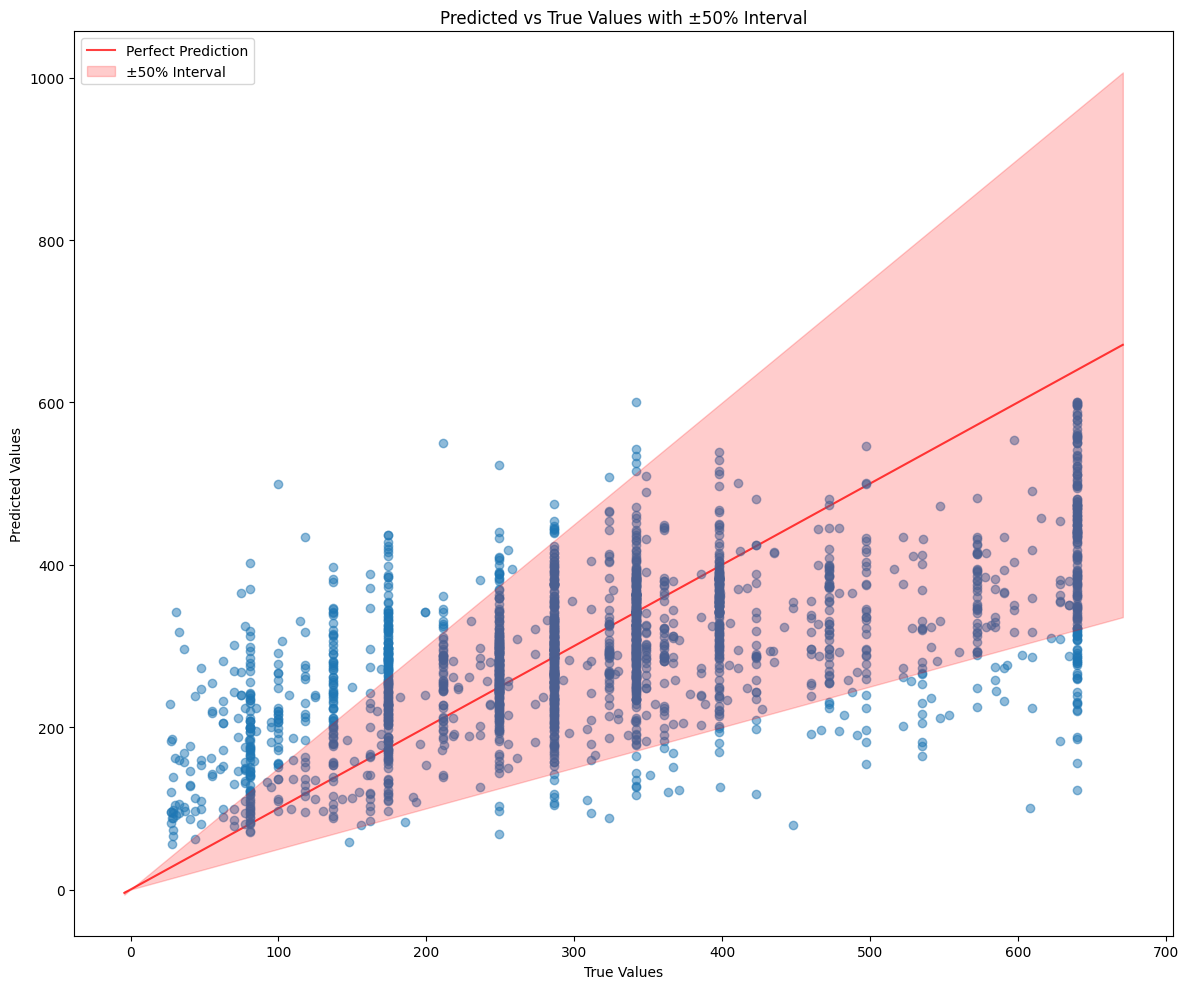

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the DataFrame
df = pd.DataFrame({
    "predicted": np.expm1(stacking_regressor_lr.predict(X_test)),
    "true": np.expm1(y_test_log)
})

# Create the plot
plt.figure(figsize=(12, 10))

# Create the scatter plot
plt.scatter(df['true'], df['predicted'], alpha=0.5)

# Get the axis limits
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Add perfect prediction line
plt.plot(lims, lims, 'r-', alpha=0.75, zorder=0, label='Perfect Prediction')

# Add ±5% interval
plt.fill_between(lims, 
                 [0.50 * lim for lim in lims],  # Lower bound: -5%
                 [1.50 * lim for lim in lims],  # Upper bound: +5%
                 alpha=0.2, color='red', label='±50% Interval')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values with ±50% Interval')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

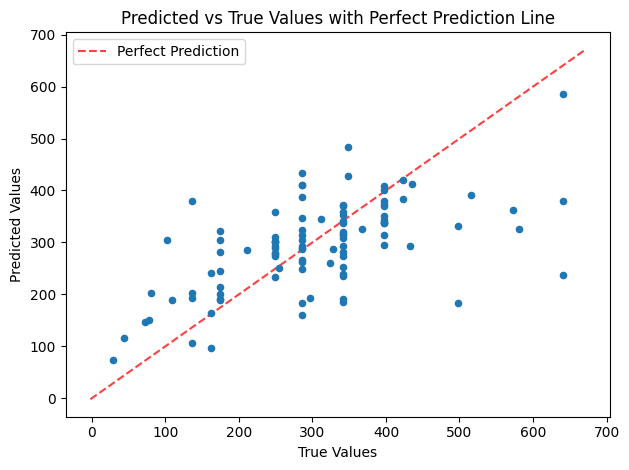

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the DataFrame
df = pd.DataFrame({
    "predicted": np.expm1(best_stacking_ridge.predict(X_test)),
    "true": np.expm1(y_test_log)
})

# Create the scatter plot
plt.figure(figsize=(10, 8))
df.head(100).plot(kind='scatter', x='true', y='predicted')

# Get the axis limits
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Add perfect prediction line
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values with Perfect Prediction Line')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

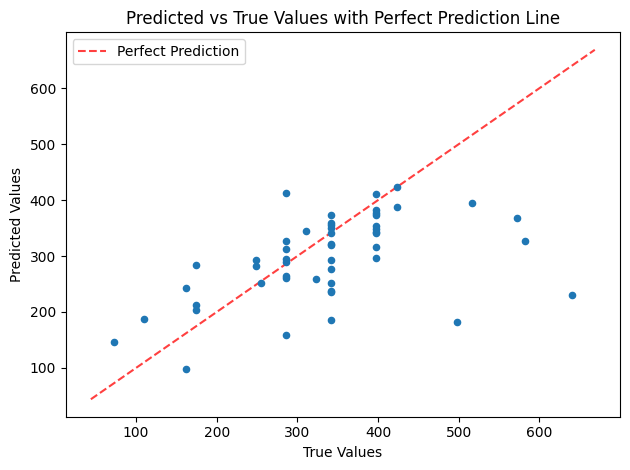

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the DataFrame
df = pd.DataFrame({
    "predicted": np.expm1(best_stacking_lasso.predict(X_test)),
    "true": np.expm1(y_test_log)
})

# Create the scatter plot
plt.figure(figsize=(10, 8))
df.head(50).plot(kind='scatter', x='true', y='predicted')

# Get the axis limits
ax = plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Add perfect prediction line
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values with Perfect Prediction Line')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<Axes: xlabel='predicted', ylabel='true'>

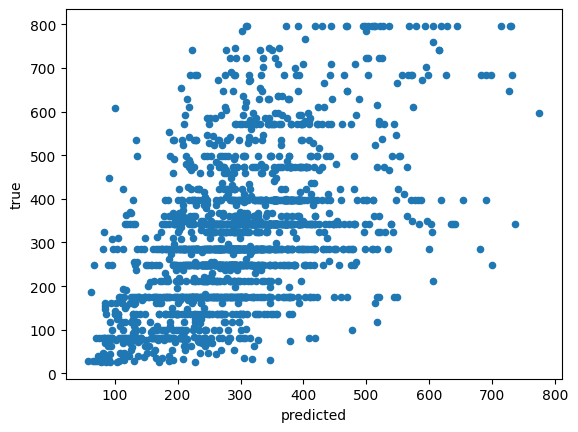

In [74]:
import matplotlib.pyplot as plt

results = pd.DataFrame({"predicted":  np.expm1( stacking_regressor.predict(X_test)), "true": y_test_actual})
# plt.scatter(np.expm1( stacking_regressor.predict(X_test)), y_test_actual)
results[(results["predicted"]<800) & (results["true"]<800)].plot.scatter(x="predicted", y="true")